# Introduction

## Foreword

Contains all selected training code for models (went through 11 different models, so will only include relevant ones here).

Outputs exported to `../Results/model_scores.csv`

## Problem Statement

The rapid evolution of generative artificial intelligence (GPAI, LLMs) social media has rapidly increased the public’s access to powerful, deceptive tools. One such concern is the increasing prevalence of deepfake images, which pose a significant threat to public trust and undermines the epistemic integrity of visual media. (Source).

These manipulated images can be utilized to spread false information, manipulate public opinion, and polarize communities, which can have serious consequences for both social and political discourse. In this project, we aim to develop a machine learning model that can detect differences between deepfakes and real images to combat the spread of manipulated visual media and protect the integrity of social discourse.

## Imports, Global Variables, and Helper Functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
import sys

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, TrueNegatives, TruePositives, FalsePositives, FalseNegatives

In [ ]:
# Importing global variables
sys.path.append('../../Helper')
import config

# Setting random value
set_random_seed(config.random_seed_value)

## Data Loading

In [ ]:
# Extracting w/h
image_shape = img_to_array(load_img("../../../Data/Train/Real/real_1.jpg")).shape
w = image_shape[0]
h = image_shape[1]

In [ ]:
# Setting filepaths to image data
train_directory = "../../../Data/Train"
validation_directory = "../../../Data/Validation/"
test_directory = "../../../Data/Test/"
directories = [train_directory, validation_directory, test_directory]

In [ ]:
# Loading data
mega_data = []
for i in range(3):
    mega_data.append(image_dataset_from_directory(
        directory=directories[i],
        image_size=(w, h),
        batch_size=64,
        seed=config.random_seed_value,
        label_mode='binary'
    ))

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [ ]:
# Variable names to data
train_ds = mega_data[0]
val_ds = mega_data[1]
test_ds = mega_data[2]

# Modeling

## Baseline Model (Sequential)

### Preprocessing (Topology + Compiling)

In [ ]:
# instantiate
model = Sequential()

# input layer
model.add(Input(shape=(w, h, 3)))
model.add(Rescaling(1./255))
model.add(BatchNormalization())

# convolutional layers
model.add(Dropout(0.3))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))
model.add(Conv2D(8, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# hidden layers
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())

model.add(Dropout(0.3))
model.add(Dense(8, activation="relu"))
model.add(BatchNormalization())

# output layer
model.add(Dense(1, activation="sigmoid"))

# compile
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=BinaryCrossentropy(),
    metrics=config.standard_metrics
)

### Fitting

In [ ]:
# es = EarlyStopping(patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0005)
res = model.fit(train_ds,
                validation_data=val_ds, 
                epochs=20,
                callbacks=[reduce_lr])

Epoch 1/20
2188/2188 [==============================] - 8408s 4s/step - loss: 0.4627 - binary_accuracy: 0.7749 - auc: 0.8582 - precision: 0.7561 - recall: 0.8115 - true_negatives: 51951.0000 - true_positives: 57086.0000 - false_positives: 18412.0000 - false_negatives: 13257.0000 - val_loss: 1.1873 - val_binary_accuracy: 0.7163 - val_auc: 0.7958 - val_precision: 0.6863 - val_recall: 0.8007 - val_true_negatives: 12398.0000 - val_true_positives: 15843.0000 - val_false_positives: 7243.0000 - val_false_negatives: 3944.0000 - lr: 0.0050
Epoch 2/20
2188/2188 [==============================] - 6818s 3s/step - loss: 0.3664 - binary_accuracy: 0.8339 - auc: 0.9153 - precision: 0.8190 - recall: 0.8572 - true_negatives: 56741.0000 - true_positives: 60008.0000 - false_positives: 13260.0000 - false_negatives: 9993.0000 - val_loss: 0.6442 - val_binary_accuracy: 0.7119 - val_auc: 0.8548 - val_precision: 0.6420 - val_recall: 0.9628 - val_true_negatives: 9020.0000 - val_true_positives: 19050.0000 - val_f

### Saving Files

In [ ]:
'''
loss: 0.2020 - binary_accuracy: 0.9176 - auc: 0.9747 - precision: 0.9100 - recall: 0.9270 - true_negatives: 63583.0000 - true_positives: 64889.0000 - false_positives: 6418.0000 - false_negatives: 5112.0000
val_loss: 0.4216 - val_binary_accuracy: 0.8216 - val_auc: 0.9169 - val_precision: 0.7723 - val_recall: 0.9139 - val_true_negatives: 14310.0000 - val_true_positives: 18083.0000 - val_false_positives: 5331.0000 - val_false_negatives: 1704.0000 - lr: 1.0000e-03
'''
data = [[0.2020, 0.9176, 0.9100, 0.9270, 0.9747, 5112, 6418, 63583, 64889, 0.4216, 0.8216, 0.7723, 0.9139, 0.9169, 1704, 5331, 14310, 18083]]
df = pd.DataFrame(data=np.array(data), columns=config.column_names, index=["cnn_baseline"])
df

train_loss  train_acc  train_precision  train_recall  train_auc  \
cnn_baseline       0.202     0.9176             0.91         0.927     0.9747   

              train_fn  train_fp  train_tn  train_tp  val_loss  val_acc  \
cnn_baseline    5112.0    6418.0   63583.0   64889.0    0.4216   0.8216   

              val_precision  val_recall  val_auc  val_fn  val_fp   val_tn  \
cnn_baseline         0.7723      0.9139   0.9169  1704.0  5331.0  14310.0   

               val_tp  
cnn_baseline  18083.0

In [ ]:
test = pd.read_csv("../../Results/model_eval.csv")
test

Unnamed: 0  train_loss  train_acc  train_precision  \
0                     models         NaN        NaN              NaN   
1                    model_1    0.046418   0.983007         0.981008   
2  efficientnetv2-b0_retrain    0.003119   0.977746         0.994270   
3                   cnn_reid    0.052528   0.978279         0.998641   

   train_recall  train_auc  train_fn  train_fp  train_tn  train_tp  val_loss  \
0           NaN        NaN       NaN       NaN       NaN       NaN       NaN   
1      0.985086   0.998207    1044.0    1335.0   68666.0   68957.0  0.728149   
2      0.963431   0.993228   86257.0   89180.0    3385.0     608.0  0.119601   
3      0.963815   0.993872   67389.0   69572.0    2612.0     429.0  0.367717   

    val_acc  val_precision  val_recall   val_auc   val_fn   val_fp   val_tn  \
0       NaN            NaN         NaN       NaN      NaN      NaN      NaN   
1  0.859973       0.848666    0.877445  0.918686   2425.0   3096.0  16545.0   
2  0.965126       0.991854    0.949819  0.982413  18614.0  19439.0   1027.0   
3  0.902252       0.965261    0.853517  0.972052  16340.0  19234.0   3301.0   

    val_tp  
0      NaN  
1  17362.0  
2    348.0  
3    553.0

In [ ]:
df.to_csv("../../Results/model_eval.csv", mode="a", header=False)

In [ ]:
test = pd.read_csv("../../Results/model_eval.csv")
test

Unnamed: 0  train_loss  train_acc  train_precision  \
0                     models         NaN        NaN              NaN   
1                    model_1    0.046418   0.983007         0.981008   
2  efficientnetv2-b0_retrain    0.003119   0.977746         0.994270   
3                   cnn_reid    0.052528   0.978279         0.998641   
4               cnn_baseline    0.202000   0.917600         0.910000   

   train_recall  train_auc  train_fn  train_fp  train_tn  train_tp  val_loss  \
0           NaN        NaN       NaN       NaN       NaN       NaN       NaN   
1      0.985086   0.998207    1044.0    1335.0   68666.0   68957.0  0.728149   
2      0.963431   0.993228   86257.0   89180.0    3385.0     608.0  0.119601   
3      0.963815   0.993872   67389.0   69572.0    2612.0     429.0  0.367717   
4      0.927000   0.974700    5112.0    6418.0   63583.0   64889.0  0.421600   

    val_acc  val_precision  val_recall   val_auc   val_fn   val_fp   val_tn  \
0       NaN            NaN         NaN       NaN      NaN      NaN      NaN   
1  0.859973       0.848666    0.877445  0.918686   2425.0   3096.0  16545.0   
2  0.965126       0.991854    0.949819  0.982413  18614.0  19439.0   1027.0   
3  0.902252       0.965261    0.853517  0.972052  16340.0  19234.0   3301.0   
4  0.821600       0.772300    0.913900  0.916900   1704.0   5331.0  14310.0   

    val_tp  
0      NaN  
1  17362.0  
2    348.0  
3    553.0  
4  18083.0

## Experimental Model (EfficientNetV2L)

### Data Augmentation

In [ ]:
# Imports
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import (RandomFlip, RandomRotation, 
                                                                RandomZoom, RandomContrast)

In [ ]:
# Test on single image

train_path = '../../../Dataset/Train/'

img = img_to_array(load_img(train_path + 'Fake/Fake_9.jpg'))

w = img.shape[0]
h = img.shape[1]

exp_img = np.expand_dims(img, axis=0)

In [ ]:
# Setting up Augmentation model

data_aug = Sequential([
    RandomFlip('horizontal', input_shape=(h,w,3)),
    RandomRotation(0.3),
    RandomZoom(0.3),
    RandomContrast(0.3)
])

In [ ]:
# Test on single image
data_aug(exp_img)

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[196.12984   , 165.4487    , 144.61728   ],
         [196.73056   , 163.87068   , 141.74945   ],
         [196.88684   , 161.8581    , 139.00562   ],
         ...,
         [255.        , 255.        , 255.        ],
         [254.61365   , 255.        , 255.        ],
         [254.79167   , 255.        , 255.        ]],

        [[194.5486    , 164.73442   , 144.43854   ],
         [196.44452   , 164.07281   , 142.35818   ],
         [197.75334   , 162.76582   , 140.11298   ],
         ...,
         [255.        , 255.        , 255.        ],
         [255.        , 255.        , 255.        ],
         [255.        , 255.        , 255.        ]],

        [[193.11328   , 163.62352   , 144.09384   ],
         [196.12502   , 163.48703   , 142.43027   ],
         [198.57384   , 163.07516   , 140.82861   ],
         ...,
         [255.        , 255.        , 255.        ],
         [255.        , 255.        , 255.      

In [ ]:
# Squeeze to normal image dimension
new_img = np.squeeze(exp_img)
new_img.shape

(256, 256, 3)

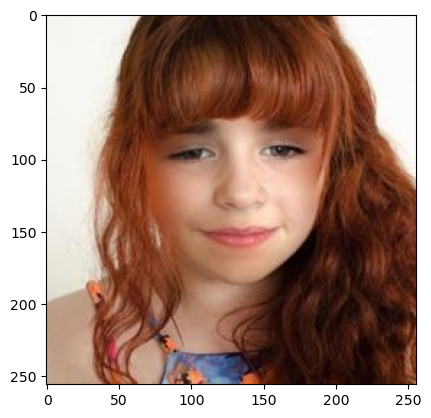

In [ ]:
# Show new image
plt.imshow(new_img * 1./255);

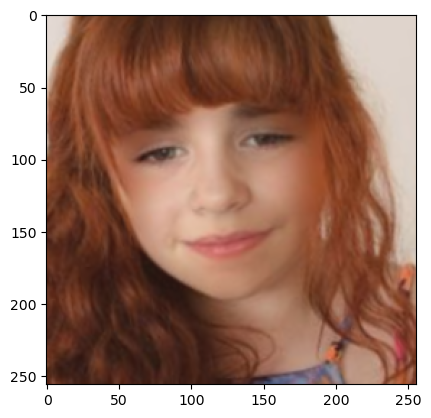

In [ ]:
# Finalized function 
new_img_aug = data_augmentation(exp_img)
new_img = np.squeeze(new_img_aug)
plt.imshow(new_img * 1./255);

### Preprocessing (Topology + Compiling)

In [ ]:
model7 = Sequential()

effnet_V2L_pretrained = EfficientNetV2L(
    weights='imagenet',   
    input_shape=(h,w,3), 
    include_top=False,
    include_preprocessing=True      #Efficientnet_2L expects [-1, 1] range, if set to False
)

effnet_V2L_pretrained.trainable = False

model7.add(data_aug)
model7.add(effnet_V2L_pretrained)

model7.add(GlobalAveragePooling2D())

model7.add(Dense(256, activation='relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.3))

model7.add(Dense(units = 1, activation='sigmoid'))
model7.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 8, 8, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                      

In [ ]:
# Compile
model7.compile(
    optimizer='adam',
    loss = 'bce',
    metrics = ['acc', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()]
)

### Fitting

In [ ]:
# es = EarlyStopping(patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0005)
res = model.fit(train_ds,
                validation_data=val_ds, 
                epochs=20,
                callbacks=[reduce_lr])

Epoch 1/20
2188/2188 [==============================] - 8408s 4s/step - loss: 0.4627 - binary_accuracy: 0.7749 - auc: 0.8582 - precision: 0.7561 - recall: 0.8115 - true_negatives: 51951.0000 - true_positives: 57086.0000 - false_positives: 18412.0000 - false_negatives: 13257.0000 - val_loss: 1.1873 - val_binary_accuracy: 0.7163 - val_auc: 0.7958 - val_precision: 0.6863 - val_recall: 0.8007 - val_true_negatives: 12398.0000 - val_true_positives: 15843.0000 - val_false_positives: 7243.0000 - val_false_negatives: 3944.0000 - lr: 0.0050
Epoch 2/20
2188/2188 [==============================] - 6818s 3s/step - loss: 0.3664 - binary_accuracy: 0.8339 - auc: 0.9153 - precision: 0.8190 - recall: 0.8572 - true_negatives: 56741.0000 - true_positives: 60008.0000 - false_positives: 13260.0000 - false_negatives: 9993.0000 - val_loss: 0.6442 - val_binary_accuracy: 0.7119 - val_auc: 0.8548 - val_precision: 0.6420 - val_recall: 0.9628 - val_true_negatives: 9020.0000 - val_true_positives: 19050.0000 - val_f

In [ ]:
h7 = model7.fit(train, validation_data = val, epochs = 10, callbacks = [reduce_lr, es])

Epoch 1/10
4376/4376 [==============================] - 2174s 493ms/step - loss: 0.5328 - acc: 0.7320 - precision_4: 0.7242 - recall_4: 0.7492 - auc_4: 0.8091 - false_negatives_4: 17556.0000 - false_positives_4: 19971.0000 - true_negatives_4: 50037.0000 - true_positives_4: 52446.0000 - val_loss: 0.4999 - val_acc: 0.7614 - val_precision_4: 0.7886 - val_recall_4: 0.7168 - val_auc_4: 0.8441 - val_false_negatives_4: 5608.0000 - val_false_positives_4: 3804.0000 - val_true_negatives_4: 15851.0000 - val_true_positives_4: 14192.0000 - lr: 0.0010
Epoch 2/10
4376/4376 [==============================] - 2089s 477ms/step - loss: 0.4975 - acc: 0.7530 - precision_4: 0.7434 - recall_4: 0.7726 - auc_4: 0.8352 - false_negatives_4: 15915.0000 - false_positives_4: 18670.0000 - true_negatives_4: 51338.0000 - true_positives_4: 54087.0000 - val_loss: 0.4801 - val_acc: 0.7704 - val_precision_4: 0.8098 - val_recall_4: 0.7090 - val_auc_4: 0.8568 - val_false_negatives_4: 5762.0000 - val_false_positives_4: 3297.

In [ ]:
# Evaluate last epoch Train and Test Loss and Accuracy scores
print(f"Train Loss: {h7.history['loss'][-1]}\n\
Val Loss: {h7.history['val_loss'][-1]}\n\
Train Acc: {h7.history['acc'][-1]}\n\
Val Acc: {h7.history['val_acc'][-1]}")

Train Loss: 0.466923326253891
Val Loss: 0.4741072356700897
Train Acc: 0.7735375761985779
Val Acc: 0.7795209884643555


### Saving Files

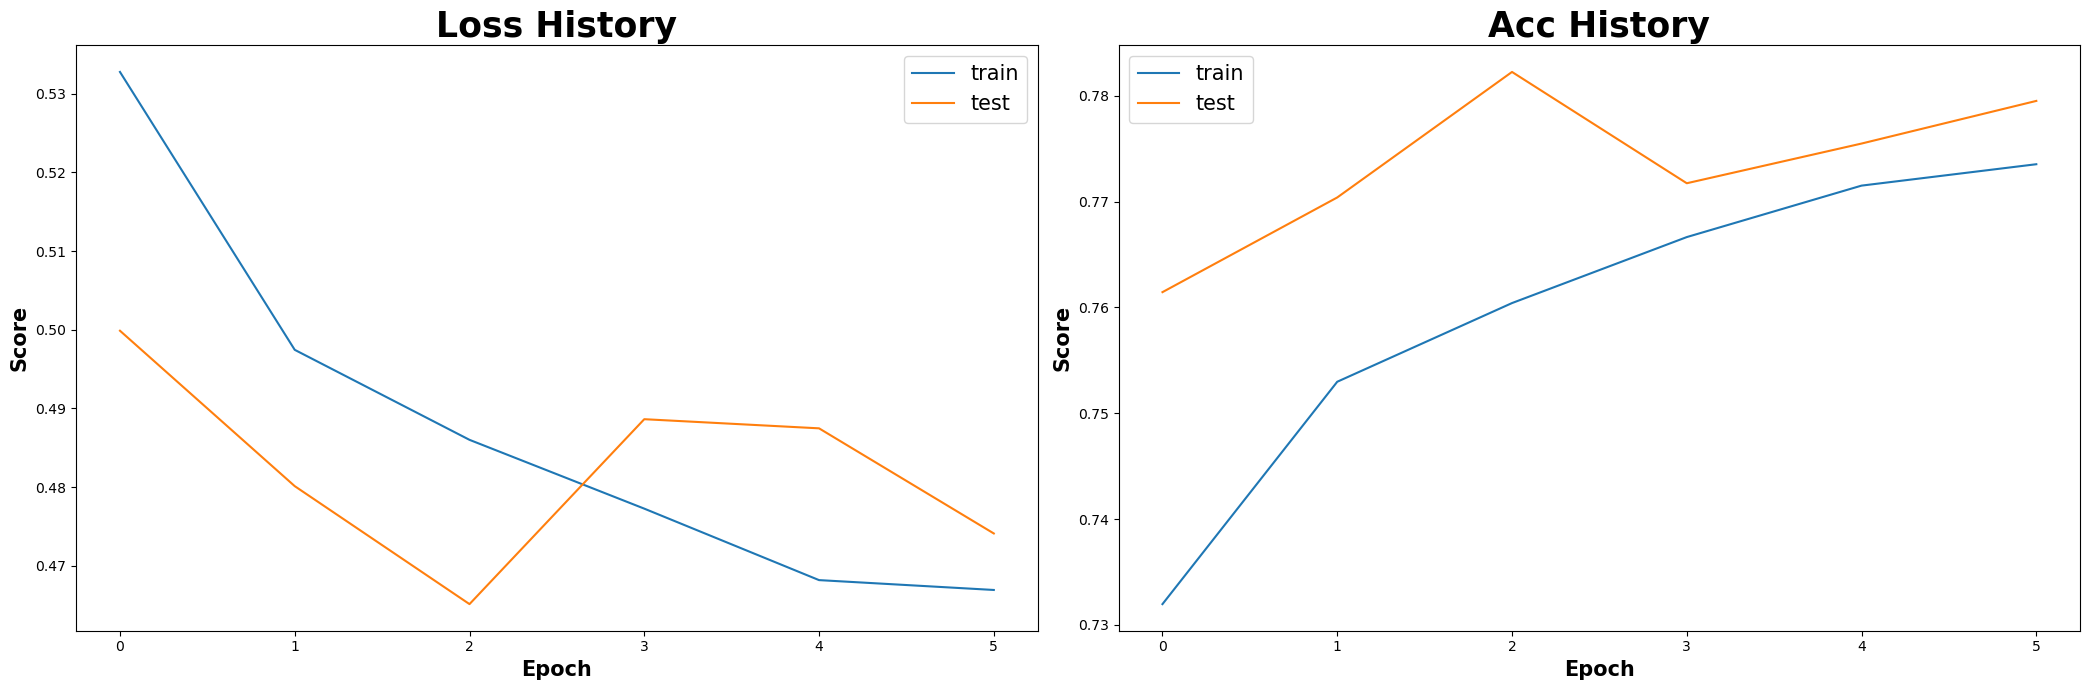

<Figure size 640x480 with 0 Axes>

In [ ]:
config.graph_me(h7, ['acc'])

plt.savefig('model7_r.png')

plt.show();

In [ ]:
# Append last epoch scores to model_eval.csv 
model_scores_to_csv(model7, h7, 'model_7')

In [ ]:
df = pd.read_csv('../../Results/model_eval_anna.csv')

# Set 'models' column as the index
df.set_index('Unnamed: 0', inplace=True)

# Drop the row with index label 'models'
df.drop('models', inplace=True)

# Rename the index to 'models'
df.index.name = 'models'

df

train_loss  train_acc  train_precision  train_recall  train_auc   
models                                                                     
model_1    0.046418   0.983007         0.981008      0.985086   0.998207  \
model_2    0.027057   0.990694         0.990238      0.991157   0.999172   
model_3    0.037152   0.986929         0.986345      0.987529   0.998717   
model_4    0.036311   0.986794         0.986300      0.987300   0.998825   
model_5    0.092766   0.974295         0.973017      0.975644   0.996733   
model_6    0.135484   0.946475         0.943747      0.949544   0.988435   
model_7    0.466923   0.773538         0.764625      0.790349   0.857355   

         train_fn  train_fp  train_tn  train_tp  val_loss   val_acc   
models                                                                
model_1    1044.0    1335.0   68666.0   68957.0  0.728149  0.859973  \
model_2     619.0     684.0   69324.0   69383.0  0.457394  0.910100   
model_3     873.0     957.0   69051.0   69129.0  0.487295  0.792878   
model_4     889.0     960.0   69048.0   69113.0  0.260117  0.918135   
model_5    1705.0    1894.0   68114.0   68297.0  0.418766  0.878393   
model_6    3532.0    3962.0   66046.0   66470.0  0.286400  0.891167   
model_7   14676.0   17031.0   52977.0   55326.0  0.474107  0.779521   

         val_precision  val_recall   val_auc  val_fn  val_fp   val_tn   val_tp  
models                                                                          
model_1       0.848666    0.877445  0.918686  2425.0  3096.0  16545.0  17362.0  
model_2       0.876349    0.955707  0.957809   877.0  2670.0  16985.0  18923.0  
model_3       0.840637    0.724647  0.886185  5452.0  2720.0  16935.0  14348.0  
model_4       0.914167    0.923586  0.969956  1513.0  1717.0  17938.0  18287.0  
model_5       0.827841    0.956616  0.957764   859.0  3939.0  15716.0  18941.0  
model_6       0.887456    0.896869  0.956441  2042.0  2252.0  17403.0  17758.0  
model_7       0.822347    0.715152  0.865756  5640.0  3059.0  16596.0  14160.0

## Best Model (EfficientNetV2B0)

### Preprocessing (Topology + Compiling)

In [ ]:
model = Sequential()

effnet_V2L = EfficientNetV2B0(
    weights='imagenet',   
    input_shape=(h,w,3), 
    include_top=False,
    pooling='max',
    classes = 2,
    include_preprocessing=True     #Efficientnet_2L expects [-1, 1] range, if set to False
)

effnet_V2L.trainable = True

model.add(effnet_V2L)

model.add(Dense(1, activation='sigmoid'))

24289280/24274472 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='bce',
    metrics=['acc']
)

### Fitting

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2023-05-18 17:28:48.608097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - ETA: 0s - loss: 0.3019 - acc: 0.8872

2023-05-18 18:28:05.681589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - 3784s 2s/step - loss: 0.3019 - acc: 0.8872 - val_loss: 0.2602 - val_acc: 0.9033
Epoch 2/10
2188/2188 [==============================] - 3909s 2s/step - loss: 0.1009 - acc: 0.9617 - val_loss: 0.1820 - val_acc: 0.9311
Epoch 3/10
2188/2188 [==============================] - 3566s 2s/step - loss: 0.0610 - acc: 0.9765 - val_loss: 0.1432 - val_acc: 0.9465
Epoch 4/10
2188/2188 [==============================] - 3557s 2s/step - loss: 0.0392 - acc: 0.9851 - val_loss: 0.1265 - val_acc: 0.9544
Epoch 5/10
2188/2188 [==============================] - 3501s 2s/step - loss: 0.0252 - acc: 0.9910 - val_loss: 0.1173 - val_acc: 0.9590
Epoch 6/10
2188/2188 [==============================] - 3449s 2s/step - loss: 0.0170 - acc: 0.9944 - val_loss: 0.1168 - val_acc: 0.9614
Epoch 7/10
2188/2188 [==============================] - 3435s 2s/step - loss: 0.0120 - acc: 0.9961 - val_loss: 0.1092 - val_acc: 0.9649
Epoch 8/10
2188/2188 [==============================] - 358

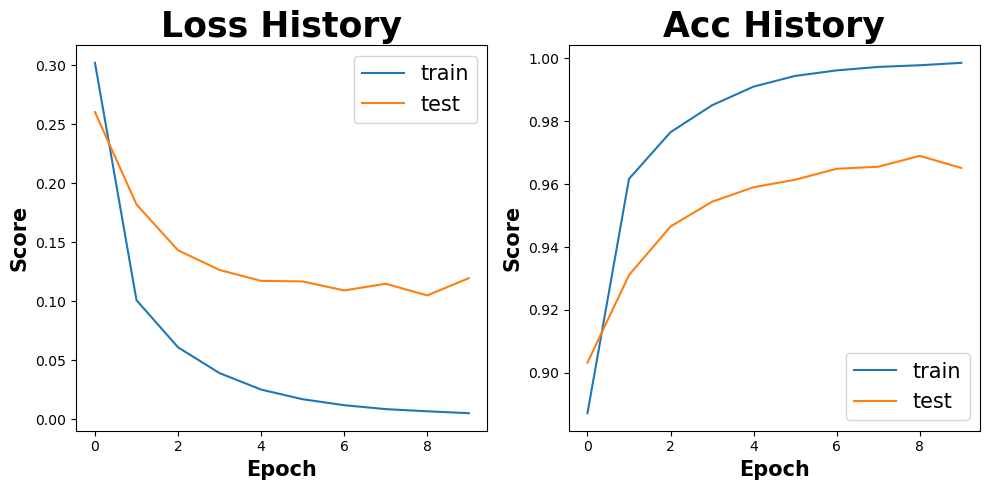

In [ ]:
config.graph_me(history, ['acc'])